# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items, popularity_recommendation
from src.recommenders import MainRecommender

In [2]:
data = pd.read_csv('../data/retail_train.csv')
item_features = pd.read_csv('../data/product.csv')
user_features = pd.read_csv('../data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
data.user_id.nunique()

2499

In [4]:
data_train_lvl_1.user_id.nunique()

2498

In [5]:
data_val_lvl_1.user_id.nunique()

2154

In [6]:
data_val_lvl_2.user_id.nunique()

2042

In [7]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

D:\Jupiter\Recommendation\recsys-tutorial-master\src\utils.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


Decreased # items from 83685 to 5001


C:\Users\ataga\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [8]:
recommender = MainRecommender(data_train_lvl_1)

In [9]:
recommender.get_als_recommendations(2496, N=5)

[844179, 1004906, 1020581, 916122, 12810393]

In [10]:
recommender.get_own_recommendations(2496, N=5)

[900770, 10285187, 10285149, 992870, 855672]

In [11]:
recommender.get_similar_items_recommendation(2496, N=5)

[904360, 1038217, 985999, 5569845, 844818]

In [12]:
recommender.get_similar_users_recommendation(2496, N=5)

[910151, 927851, 939602, 1404121, 901711]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [13]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [14]:
# your_code

In [15]:
cold_users = np.setdiff1d(result_lvl_1['user_id'], data_train_lvl_1['user_id']).tolist()

result_lvl_1 = result_lvl_1[~result_lvl_1['user_id'].isin(cold_users)]

##### Рекомендации через стардартные библиотеки implicit

In [16]:
%%time

# Рекомендации через стардартные библиотеки implicit
result_lvl_1['als'] = result_lvl_1['user_id'].apply(
    lambda x: recommender.get_als_recommendations(x, N=50)
)

result_lvl_1.apply(lambda row: recall_at_k(row['als'], row['actual']), axis=1).mean()

Wall time: 1min 22s


0.015935425404928892

#### Рекомендуем товары среди тех, которые юзер уже купил

In [17]:
%%time

# Рекомендуем товары среди тех, которые юзер уже купил
result_lvl_1['own_recommendations'] = result_lvl_1['user_id'].apply(
    lambda x: recommender.get_own_recommendations(x, N=50)
)

result_lvl_1.apply(lambda row: recall_at_k(row['own_recommendations'], row['actual']), axis=1).mean()

Wall time: 1min 8s


0.027722742608110137

Собственные покупки в числе рекомендованных товаров показали лучший результат.

#### Рекомендуем товары, похожие на топ-N купленных юзером товаров

In [18]:
%%time

# Рекомендуем товары, похожие на топ-N купленных юзером товаров
result_lvl_1['similar_items_recommendation'] = result_lvl_1['user_id'].apply(
    lambda x: recommender.get_similar_items_recommendation(x, N=50)
)

result_lvl_1.apply(lambda row: recall_at_k(row['similar_items_recommendation'], row['actual']), axis=1).mean()

Wall time: 47.7 s


0.010816526469925774

In [19]:
# %%time

# # Рекомендуем топ-N товаров, среди купленных похожими юзерами
# result_lvl_1['similar_users_recommendation'] = result_lvl_1['user_id'].apply(
#     lambda x: recommender.get_similar_users_recommendation(x, N=50)
# )

#### Зависимость recall@k от k

In [20]:
k_list = [20, 50, 100, 200, 500]
recall_at_k_list = []
for k in k_list:
    rec = result_lvl_1.apply(lambda row: recall_at_k(row['own_recommendations'], row['actual'], k=k), axis=1).mean()
    recall_at_k_list.append(rec)

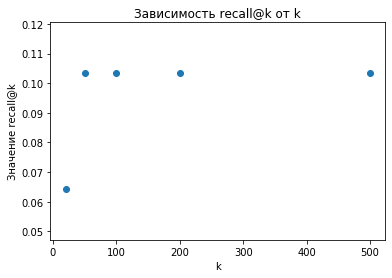

In [21]:
import matplotlib.pyplot as plt

plt.scatter(k_list, recall_at_k_list)
plt.title('Зависимость recall@k от k')
plt.xlabel('k')
plt.ylabel('Значение recall@k');

In [22]:
recall_at_k_list

[0.06425543482993358,
 0.10342265309881606,
 0.10342265309881606,
 0.10342265309881606,
 0.10342265309881606]

Список рекомендованных товаров ограничен 50-ю товарами, поэтому при k > 50 значения метрики не меняются.

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [23]:
# your_code

### Добавим фичи

In [24]:
def new_item_features(data, item_features):
    """Новые признаки для продуктов"""
    
    new_item_features = item_features.merge(data, on='item_id', how='left')
  

    ##### 1 Количество продаж и среднее количество продаж товара

    item_qnt = new_item_features.groupby(['item_id'])['quantity'].count().reset_index()
    item_qnt.rename(columns={'quantity': 'quantity_of_sales'}, inplace=True)

    item_qnt['quantity_of_sales_per_week'] = item_qnt['quantity_of_sales'] / new_item_features['week_no'].nunique()

    item_features = item_features.merge(item_qnt, on='item_id')

    ##### 2 Среднее количество продаж товара в категории в неделю

    items_in_department = new_item_features.groupby('department')['item_id'].count().reset_index().sort_values(
        'item_id', ascending=False
    )
    items_in_department.rename(columns={'item_id': 'items_in_department'}, inplace=True)

    qnt_of_sales_per_dep = new_item_features.groupby(['department'])['quantity'].count().reset_index().sort_values(
        'quantity', ascending=False
    )
    qnt_of_sales_per_dep.rename(columns={'quantity': 'qnt_of_sales_per_dep'}, inplace=True)


    items_in_department = items_in_department.merge(qnt_of_sales_per_dep, on='department')
    items_in_department['qnt_of_sales_per_item_per_dep_per_week'] = (
        items_in_department['qnt_of_sales_per_dep'] / 
        items_in_department['items_in_department'] / 
        new_item_features['week_no'].nunique()
    )
    items_in_department = items_in_department.drop(['items_in_department'], axis=1)

    item_features = item_features.merge(items_in_department, on=['department'], how='left')
    
    return item_features

In [25]:
item_features = new_item_features(data_train_lvl_2, item_features)
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,quantity_of_sales,quantity_of_sales_per_week,qnt_of_sales_per_dep,qnt_of_sales_per_item_per_dep_per_week
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,0,0.0,110316,0.136722
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,,0,0.0,202,0.053695


In [26]:
def new_user_features(data, user_features):
    """Новые признаки для пользователей"""
    
    new_user_features = user_features.merge(data, on='user_id', how='left')


    ##### Возраст
    user_features['age'] = user_features['age_desc'].replace(
        {'65+': 70, '45-54': 50, '25-34': 30, '35-44': 40, '19-24':20, '55-64':60}
    )
    user_features = user_features.drop('age_desc', axis=1)

    ##### Доход
    user_features['income'] = user_features['income_desc'].replace(
        {'35-49K': 45,
     '50-74K': 70,
     '25-34K': 30,
     '75-99K': 95,
     'Under 15K': 15,
     '100-124K': 120,
     '15-24K': 20,
     '125-149K': 145,
     '150-174K': 170,
     '250K+': 250,
     '175-199K': 195,
     '200-249K': 245}
    )
    user_features = user_features.drop('income_desc', axis=1)

    ##### Дети
    user_features['kids'] = 0
    user_features.loc[(user_features['kid_category_desc'] == '1'), 'kids'] = 1
    user_features.loc[(user_features['kid_category_desc'] == '2'), 'kids'] = 2
    user_features.loc[(user_features['kid_category_desc'] == '3'), 'kids'] = 3
    user_features = user_features.drop('kid_category_desc', axis=1)

    ##### Средний чек, средний чек в неделю
    basket = new_user_features.groupby(['user_id'])['sales_value'].sum().reset_index()

    baskets_qnt = new_user_features.groupby('user_id')['basket_id'].count().reset_index()
    baskets_qnt.rename(columns={'basket_id': 'baskets_qnt'}, inplace=True)

    average_basket = basket.merge(baskets_qnt)

    average_basket['average_basket'] = average_basket.sales_value / average_basket.baskets_qnt
    average_basket['sum_per_week'] = average_basket.sales_value / new_user_features.week_no.nunique()

    average_basket = average_basket.drop(['sales_value', 'baskets_qnt'], axis=1)

    user_features = user_features.merge(average_basket)

    return user_features

In [27]:
user_features = new_user_features(data_train_lvl_2, user_features)
user_features.head(2)

,marital_status_code,homeowner_desc,hh_comp_desc,household_size_desc,user_id,age,income,kids,average_basket,sum_per_week
0,A,Homeowner,2 Adults No Kids,2,1,70,45,0,2.569774,56.963333
1,A,Homeowner,2 Adults No Kids,2,7,50,70,0,2.085000,31.275000


#### Фичи пары user_id - item_id

- (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
- (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
- (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

### Предобработка обучающего и валидационного датасетов

In [28]:
# 2154 users

In [29]:
def train_test_preprocessing(data):
    """Подготовка обучающего и валидационного датасетов, разбиение на X и y"""
    
    users_lvl_2 = pd.DataFrame(data['user_id'].unique())

    users_lvl_2.columns = ['user_id']

    # Пока только warm start
    train_users = data_train_lvl_1['user_id'].unique()
    train_users.shape

    users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

    # Рекомендации на основе собственных покупок
    users_lvl_2_ = users_lvl_2.copy()
    users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(
        lambda x: recommender.get_own_recommendations(x, N=50)
    )

    s = users_lvl_2.apply(
        lambda x: pd.Series(x['candidates']), axis=1
    ).stack().reset_index(level=1, drop=True)

    s.name = 'item_id'

    users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)


#     # Рекомендации из топа популярных товаров
#     popular_recs = popularity_recommendation(data, n=50)
#     users_lvl_2_['top_popular_candidates'] = users_lvl_2_['user_id'].apply(lambda x: popular_recs)

#     s = users_lvl_2_.apply(
#         lambda x: pd.Series(x['top_popular_candidates']), axis=1
#     ).stack().reset_index(level=1, drop=True)

#     s.name = 'item_id'

#     users_lvl_2_ = users_lvl_2_.drop('top_popular_candidates', axis=1).join(s)

#     users_lvl_2 = pd.concat([users_lvl_2, users_lvl_2_])

    users_lvl_2['flag'] = 1

    targets_lvl_2 = data[['user_id', 'item_id']].copy()
    targets_lvl_2.head(2)

    targets_lvl_2['target'] = 1  # тут только покупки

    targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

    targets_lvl_2['target'].fillna(0, inplace= True)
    targets_lvl_2.drop('flag', axis=1, inplace=True)

    targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
    targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

    X = targets_lvl_2.drop('target', axis=1)
    y = targets_lvl_2[['target']]
    
    return X, y

In [30]:
X_train, y_train = train_test_preprocessing(data_train_lvl_2)

In [31]:
cat_feats = X_train.columns[2:].tolist()
cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'quantity_of_sales',
 'quantity_of_sales_per_week',
 'qnt_of_sales_per_dep',
 'qnt_of_sales_per_item_per_dep_per_week',
 'marital_status_code',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'age',
 'income',
 'kids',
 'average_basket',
 'sum_per_week']

In [32]:
cat_feats = ['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'quantity_of_sales',
 'quantity_of_sales_per_week',
 'qnt_of_sales_per_dep',
 'qnt_of_sales_per_item_per_dep_per_week',
#  'age_desc',
 'marital_status_code',
#  'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
#  'kid_category_desc',
 'average_basket',
 'sum_per_week']

In [33]:
X_train[cat_feats] = X_train[cat_feats].astype('category')

In [34]:
X_test, y_test = train_test_preprocessing(data_val_lvl_2)

In [35]:
X_test[cat_feats] = X_test[cat_feats].astype('category')

### LGBMClassifier

In [36]:
lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

test_preds_proba = lgb.predict_proba(X_test)[:, 1]

C:\Users\ataga\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ataga\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\ataga\anaconda3\lib\site-packages\lightgbm\basic.py:863: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


In [37]:
test_preds_proba[:10]

array([0.21176122, 0.56833012, 0.07794287, 0.14358756, 0.12740981,
       0.23653568, 0.05610473, 0.21963153, 0.05973465, 0.19424396])

In [38]:
def get_final_recomendation(X_test, test_preds_proba, data_val_lvl_2):
    """Финальный список рекомендованных товаров"""
    X_test['predict_proba'] = test_preds_proba

    X_test.sort_values(['user_id', 'predict_proba'], ascending=False, inplace=True)

    result = X_test.groupby('user_id').head(5)

    recs = result.groupby('user_id')['item_id']
    recomendations = []
    for user, preds in recs:
        recomendations.append({'user_id': user, 'recomendations': preds.tolist()})

    recomendations = pd.DataFrame(recomendations)

    result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
    result_lvl_2.columns=['user_id', 'actual']

    result_lvl_2 = result_lvl_2.merge(recomendations)
    
    return result_lvl_2

In [39]:
result_lvl_2 = get_final_recomendation(X_test, test_preds_proba, data_val_lvl_2)

In [40]:
result_lvl_2.apply(lambda row: precision_at_k(row['recomendations'], row['actual']), axis=1).mean()

0.17285644292013463

### Финальный проект

Мы уже прошли всю необходимуб теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 25%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 